# Deforestation Monitoring from the space:
 
 This Jupyter notebook provide an overview of a workflow/pipeline that utilise UP42 resources to provide a detailed picture of deforestation monitoring an the Amazons. The pipeline uses UP42 API and Python SDK to retrieve Sentinel 2 imageries over a certain area of intrest and then applies a vegetation index (NDVI) over certain time slot in a form of time series. 
P.S. : this notebook is for demo purposes. It uses UP42 documentation as main source.

## Install and import needed libraries:
UP42 python SDK and related GDAL and geospatial data management libraries 

In [2]:
import up42

In [3]:
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from shapely.geometry import box
import geojson


## Authenticate :
- with UP42 API Key
- user name and password 
It is also possible to store the authentication info to a json file and read directly from.

In [39]:
up42.authenticate(username="abdalla.eltayeb@sweco.se", password="B*SGd4gxtnyD4y#")



2023-11-21 15:25:31,260 - Authentication with UP42 successful!


## Explore UP42 cataloge of satellite imagery

In [40]:
catalog = up42.initialize_catalog()
products = catalog.get_data_products(basic=True)
print(products)


{'NEXTMap One Bundle': {'collection': 'nextmapone-bundle', 'host': 'intermap', 'data_products': {'NEXTMap One Bundle': '776cadc2-ccb7-4ca4-8077-fc679bf8376a'}}, 'Near Space Labs': {'collection': 'nsl-30cm', 'host': 'nearspacelabs', 'data_products': {'Near Space Labs': '7131f727-cdbb-46d4-a1e7-77ac38b7bd02'}}, 'Landsat 8': {'collection': 'landsat-8', 'host': 'earthsearch-aws', 'data_products': {'Level-2SP': '0d6796c4-9e0b-44e8-bb8f-3d0bc9794382'}}, 'Capella Space GEC': {'collection': 'capella-gec', 'host': 'capellaspace', 'data_products': {'Full Scene': '96072809-d820-4cf9-86dd-d3bff3337c35'}}, 'Capella Space GEO': {'collection': 'capella-geo', 'host': 'capellaspace', 'data_products': {'Full Scene': 'd66facaa-533f-49a2-849a-c2910ac9dd31'}}, 'Capella Space SICD': {'collection': 'capella-sicd', 'host': 'capellaspace', 'data_products': {'Full Scene': '8b0aed07-c565-4bf9-b719-401e692de4a6'}}, 'Capella Space SLC': {'collection': 'capella-slc', 'host': 'capellaspace', 'data_products': {'Full 

## Create a porject with a project ID

In [5]:
project = up42.initialize_project(project_id="7d6a0a0a-1a2a-459d-a54f-5b12db3baf90")


2023-11-20 20:29:03,244 - Initialized Project(name: Green-Plant Management GmbH, project_id: 7d6a0a0a-1a2a-459d-a54f-5b12db3baf90, description: NDVI time series , createdAt: 2023-11-20T18:56:55.366433Z)


## define area of intrest:
There is consideration to be taken when creating area of intrest depending on the satellite or aerial imagery source 

In [6]:
aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -55.80602463366668,
              -13.267580954511516
            ],
            [
              -55.80602463366668,
              -13.49938970772358
            ],
            [
              -55.520612343249226,
              -13.49938970772358
            ],
            [
              -55.520612343249226,
              -13.267580954511516
            ],
            [
              -55.80602463366668,
              -13.267580954511516
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

## Define search parameters

In [49]:


search_parameters = catalog.construct_search_parameters(
    collections=["sentinel-2"],
    geometry=geometry,
    start_date="2022-01-01",
    end_date="2022-06-30",
    max_cloudcover=20,
    limit=5,
)

search_results = catalog.search(search_parameters)


2023-11-21 17:41:57,480 - Searching catalog with search_parameters: {'datetime': '2022-01-01T00:00:00Z/2022-06-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((13.375966, 52.515068), (13.375966, 52.516639), (13.378314, 52.516639), (13.378314, 52.515068), (13.375966, 52.515068)),)}, 'limit': 5, 'collections': ['sentinel-2'], 'query': {'cloudCoverage': {'lte': 20}}}
2023-11-21 17:42:01,092 - 5 results returned.


### show search results in a list

In [50]:
search_results

geometry  \
0  POLYGON ((12.76074 53.19024, 13.63417 53.15941...   
1  POLYGON ((12.77776 53.22890, 13.64833 53.24195...   
2  POLYGON ((12.76567 53.19009, 13.63417 53.15941...   
3  POLYGON ((12.78285 53.22899, 13.64833 53.24195...   
4  POLYGON ((11.99466 53.21198, 13.63417 53.15941...   

                         id constellation  collection     providerName  \
0  S2A_32UQD_20220627_0_L2A    sentinel-2  sentinel-2  earthsearch-aws   
1  S2A_33UUU_20220627_0_L2A    sentinel-2  sentinel-2  earthsearch-aws   
2  S2B_32UQD_20220622_0_L2A    sentinel-2  sentinel-2  earthsearch-aws   
3  S2B_33UUU_20220622_0_L2A    sentinel-2  sentinel-2  earthsearch-aws   
4  S2A_32UQD_20220610_0_L2A    sentinel-2  sentinel-2  earthsearch-aws   

  up42:usageType                                 providerProperties  \
0         [DATA]  {'s2:datatake_type': 'INS-NOBS', 's2:degraded_...   
1         [DATA]  {'s2:datatake_type': 'INS-NOBS', 's2:degraded_...   
2         [DATA]  {'s2:datatake_type': 'INS-NOBS', 's2:degraded_...   
3         [DATA]  {'s2:datatake_type': 'INS-NOBS', 's2:degraded_...   
4         [DATA]  {'s2:datatake_type': 'INS-NOBS', 's2:degraded_...   

                    sceneId               producer           acquisitionDate  \
0  S2A_32UQD_20220627_0_L2A  european-space-agency  2022-06-27T10:16:26.583Z   
1  S2A_33UUU_20220627_0_L2A  european-space-agency  2022-06-27T10:16:25.721Z   
2  S2B_32UQD_20220622_0_L2A  european-space-agency  2022-06-22T10:16:18.552Z   
3  S2B_33UUU_20220622_0_L2A  european-space-agency  2022-06-22T10:16:17.690Z   
4  S2A_32UQD_20220610_0_L2A  european-space-agency  2022-06-10T10:26:20.468Z   

  start_datetime end_datetime  cloudCoverage  resolution deliveryTime  
0           None         None      13.816595        10.0      MINUTES  
1           None         None      13.702193        10.0      MINUTES  
2           None         None       1.072535        10.0      MINUTES  
3           None         None       1.208900        10.0      MINUTES  
4           None         None       8.202177        10.0      MINUTES

## Visuale the results of search by displayin a quick look view in RGB colours

2023-11-21 17:42:23,533 - Downloading quicklooks from provider earthsearch-aws.
2023-11-21 17:42:23,538 - Download directory: /Users/abdalla/catalog
100%|███████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


geometry  \
0  POLYGON ((12.76074 53.19024, 13.63417 53.15941...   
1  POLYGON ((12.77776 53.22890, 13.64833 53.24195...   
2  POLYGON ((12.76567 53.19009, 13.63417 53.15941...   
3  POLYGON ((12.78285 53.22899, 13.64833 53.24195...   
4  POLYGON ((11.99466 53.21198, 13.63417 53.15941...   

                         id constellation  collection     providerName  \
0  S2A_32UQD_20220627_0_L2A    sentinel-2  sentinel-2  earthsearch-aws   
1  S2A_33UUU_20220627_0_L2A    sentinel-2  sentinel-2  earthsearch-aws   
2  S2B_32UQD_20220622_0_L2A    sentinel-2  sentinel-2  earthsearch-aws   
3  S2B_33UUU_20220622_0_L2A    sentinel-2  sentinel-2  earthsearch-aws   
4  S2A_32UQD_20220610_0_L2A    sentinel-2  sentinel-2  earthsearch-aws   

  up42:usageType                                 providerProperties  \
0         [DATA]  {'s2:datatake_type': 'INS-NOBS', 's2:degraded_...   
1         [DATA]  {'s2:datatake_type': 'INS-NOBS', 's2:degraded_...   
2         [DATA]  {'s2:datatake_type': 'INS-NOBS', 's2:degraded_...   
3         [DATA]  {'s2:datatake_type': 'INS-NOBS', 's2:degraded_...   
4         [DATA]  {'s2:datatake_type': 'INS-NOBS', 's2:degraded_...   

                    sceneId               producer           acquisitionDate  \
0  S2A_32UQD_20220627_0_L2A  european-space-agency  2022-06-27T10:16:26.583Z   
1  S2A_33UUU_20220627_0_L2A  european-space-agency  2022-06-27T10:16:25.721Z   
2  S2B_32UQD_20220622_0_L2A  european-space-agency  2022-06-22T10:16:18.552Z   
3  S2B_33UUU_20220622_0_L2A  european-space-agency  2022-06-22T10:16:17.690Z   
4  S2A_32UQD_20220610_0_L2A  european-space-agency  2022-06-10T10:26:20.468Z   

  start_datetime end_datetime  cloudCoverage  resolution deliveryTime  
0           None         None      13.816595        10.0      MINUTES  
1           None         None      13.702193        10.0      MINUTES  
2           None         None       1.072535        10.0      MINUTES  
3           None         None       1.208900        10.0      MINUTES  
4           None         None       8.202177        10.0      MINUTES

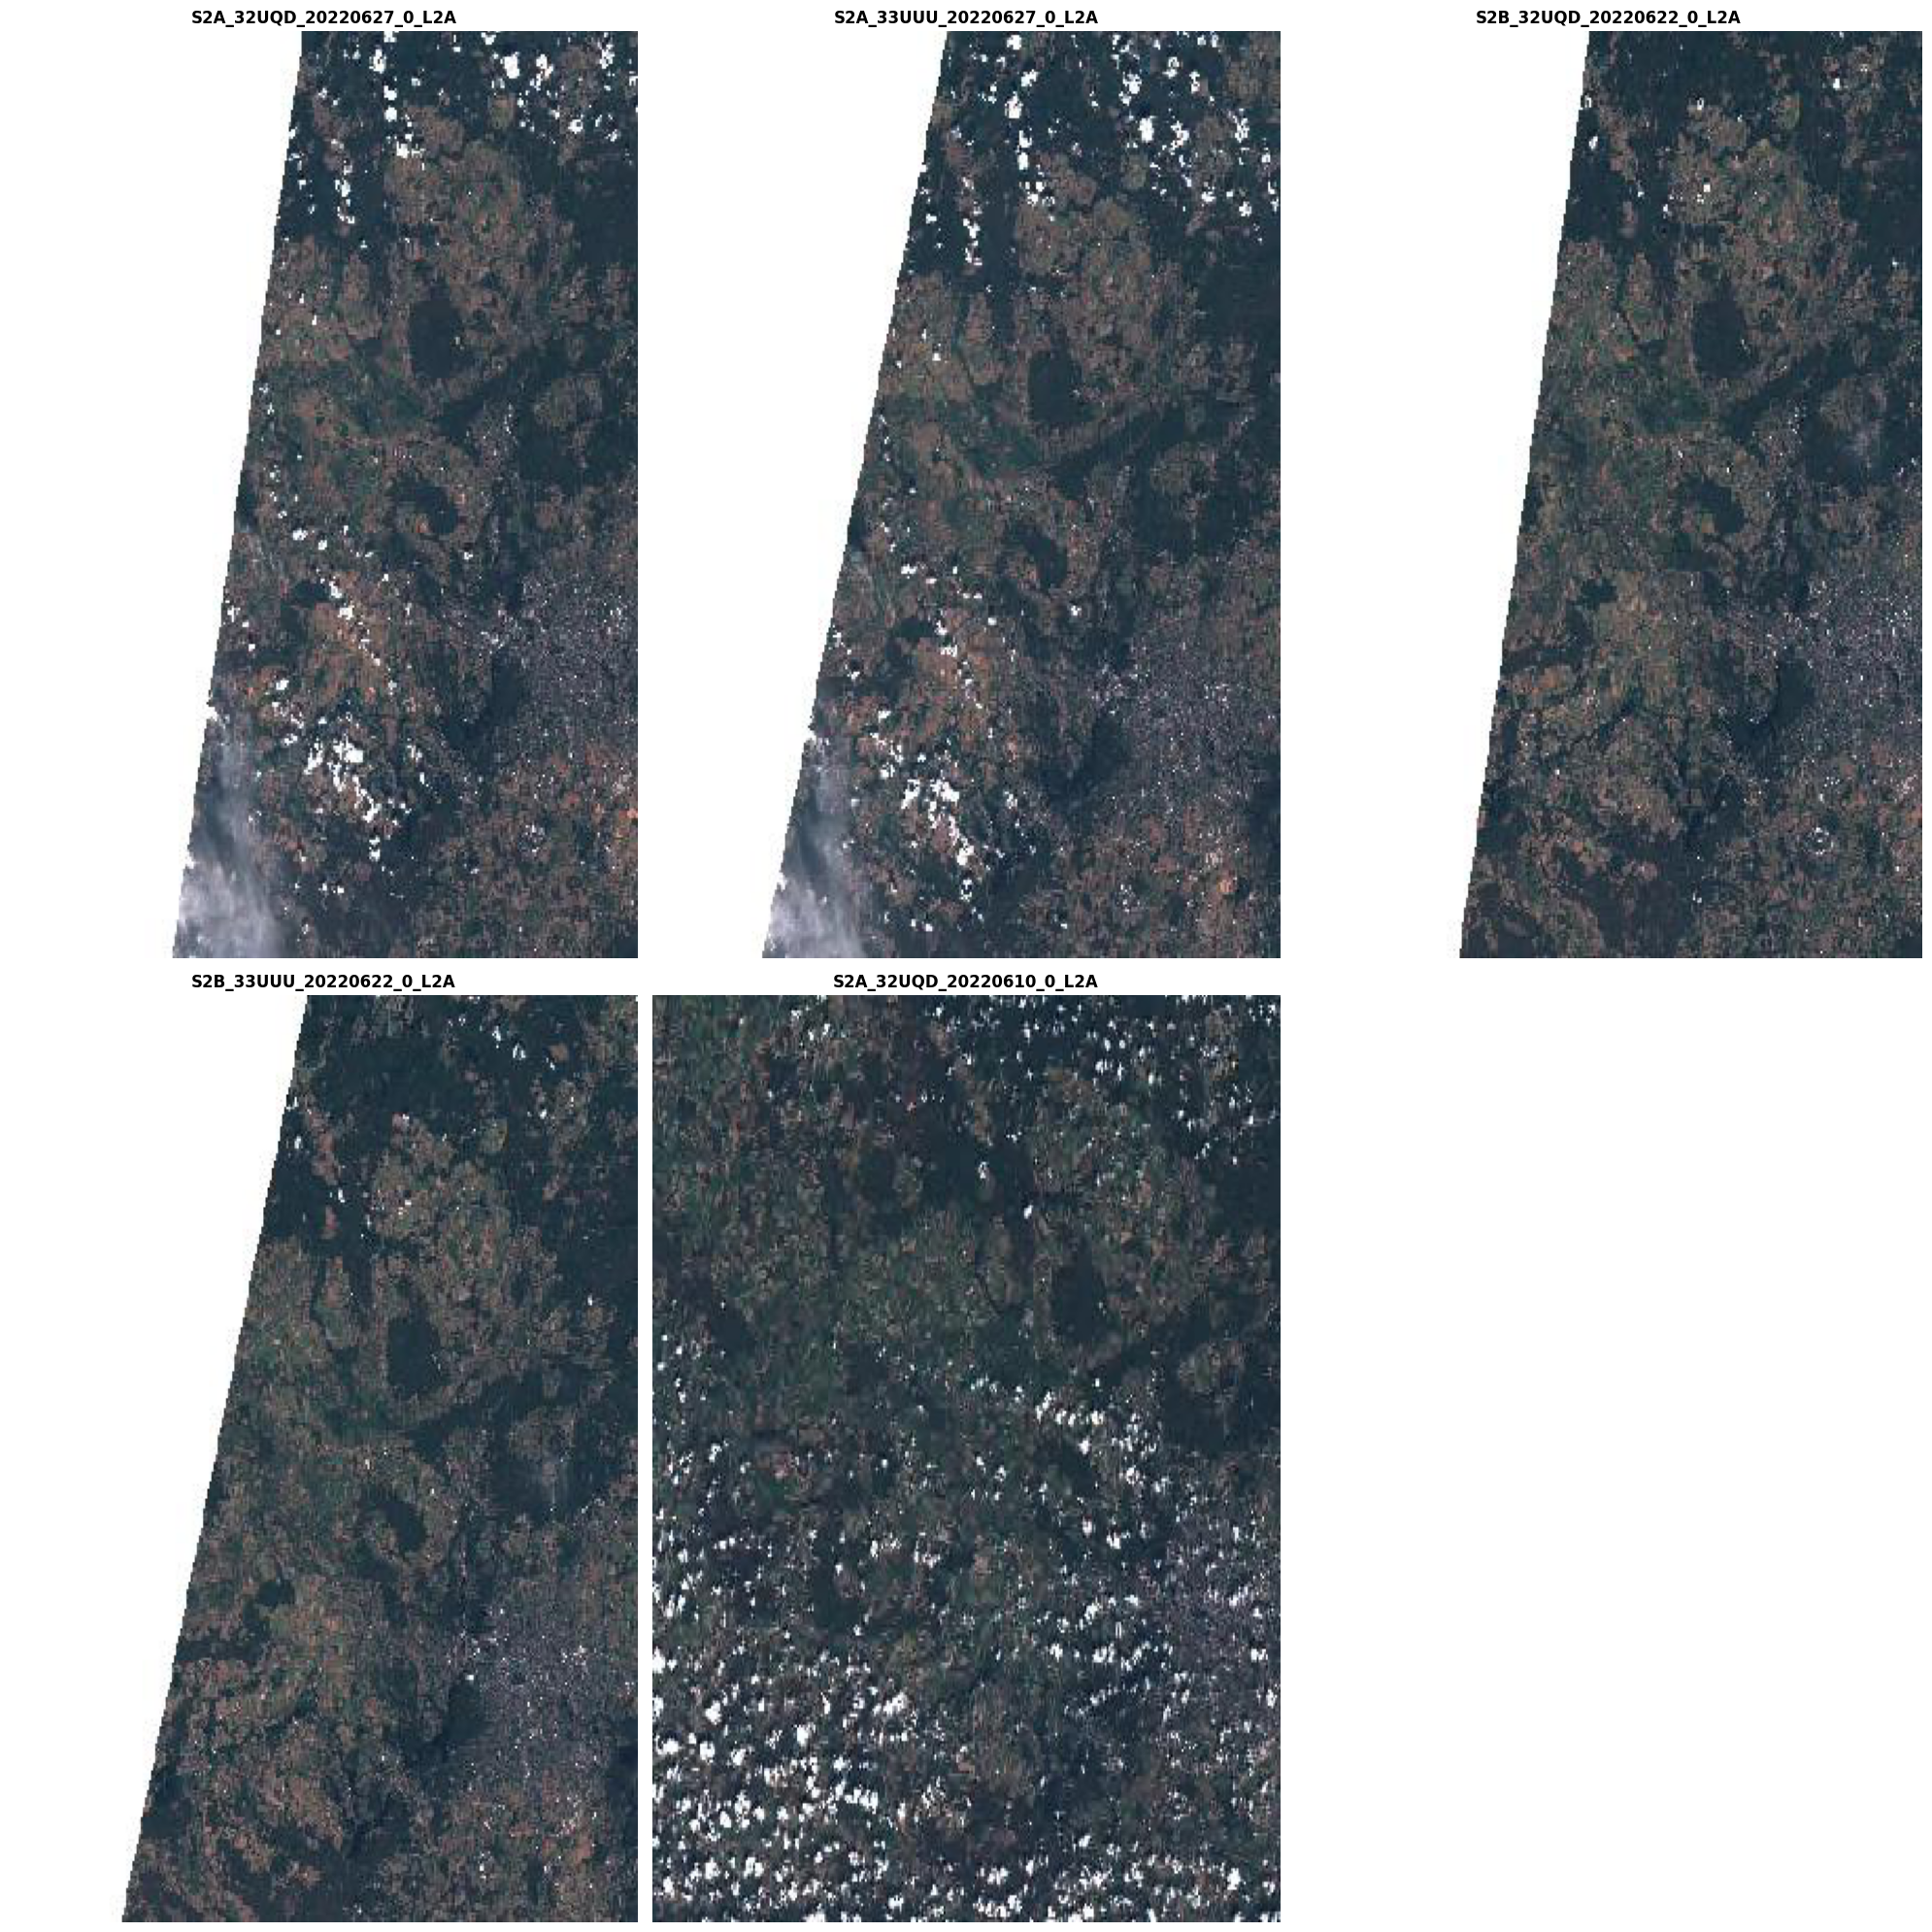

In [51]:

catalog.download_quicklooks(image_ids=search_results.id.to_list(), collection ="sentinel-2")
display(search_results.head())
catalog.plot_quicklooks(figsize=(20,20), titles=search_results.sceneId.to_list())


## Create a workflow and task to perform the NDVI and time series calculation on UP42 platform:
notice: this will consume credit 

In [27]:
workflow = project.create_workflow(name="Sentinel-2 NDVI Workflow")
workflow.add_workflow_tasks(input_tasks=["Sentinel-2 L2A Visual (GeoTIFF)"])


2023-11-21 11:42:51,971 - Created new workflow: e7f6813d-426e-4cb6-b238-3ab2be8b5e19
2023-11-21 11:42:53,035 - Added tasks to workflow: [{'name': 'esa-s2-l2a-gtiff-visual:1', 'parentName': None, 'blockId': 'c4cb8913-2ef3-4e82-a426-65ea8faacd9a'}]


##  define the workflow parameters 

In [42]:
input_parameters = workflow.construct_parameters(geometry = aoi, 
                                                geometry_operation ="bbox",
                                                start_date = "2020-01-01",
                                                end_date = "2021-01-01",
                                                limit=1)

2023-11-21 15:26:20,625 - See `workflow.get_workflow_tasks() for more detail on the parameters options.


## Estinate the cost of the workflow (in UP42 credit)

In [47]:
workflow.estimate_job(input_parameters)

2023-11-21 17:33:28,846 - Estimated: 23795-23795 Credits, Duration: 0-0 min.


{'sentinelhub-s2-aoiclipped:1': {'blockConsumption': {'resources': {'unit': 'MEGAPIXEL',
    'min': 11.010048,
    'max': 11.010048},
   'credit': {'min': 12, 'max': 12}},
  'machineConsumption': {'duration': {'min': 0, 'max': 0},
   'credit': {'min': 1, 'max': 1}}},
 'ndvi:1': {'blockConsumption': {'resources': {'unit': 'SQUARE_KM',
    'min': 951.217471,
    'max': 951.217471},
   'credit': {'min': 23781, 'max': 23781}},
  'machineConsumption': {'duration': {'min': 0, 'max': 0},
   'credit': {'min': 1, 'max': 1}}}}

 ## Run the workflow/job as test to check if everything was fine 

In [45]:
workflow.test_job(input_parameters, track_status= True)

2023-11-21 17:31:36,453 - +++++++++++++++++++++++++++++++++
2023-11-21 17:31:36,456 - Running this job as Test Query...
2023-11-21 17:31:36,457 - +++++++++++++++++++++++++++++++++
2023-11-21 17:31:36,458 - Selected input_parameters: {'sentinelhub-s2-aoiclipped:1': {'bbox': [-55.80602463366668, -13.49938970772358, -55.520612343249226, -13.267580954511516], 'time': '2020-01-01T00:00:00Z/2021-01-01T23:59:59Z', 'limit': 1, 'zoom_level': 14, 'time_series': None, 'max_cloud_cover': 100}, 'ndvi:1': {'output_original_raster': False}, 'config': {'mode': 'DRY_RUN'}}
2023-11-21 17:31:46,304 - Created and running new job: d03852ed-ea8b-4ce9-ad50-1051043892ca.
2023-11-21 17:31:46,558 - Tracking job status continuously, reporting every 30 seconds...
2023-11-21 17:32:07,559 - Job finished successfully! - d03852ed-ea8b-4ce9-ad50-1051043892ca


Job(name: Sentinel-2 NDVI Workflow_py, job_id: d03852ed-ea8b-4ce9-ad50-1051043892ca, mode: DRY_RUN, status: SUCCEEDED, startedAt: 2023-11-21T16:31:46Z, finishedAt: 2023-11-21T16:32:01Z, workflow_name: Sentinel-2 NDVI Workflow, input_parameters: {'config': {'mode': 'DRY_RUN'}, 'ndvi:1': {'output_original_raster': False}, 'sentinelhub-s2-aoiclipped:1': {'bbox': [-55.80602463366668, -13.49938970772358, -55.520612343249226, -13.267580954511516], 'time': '2020-01-01T00:00:00Z/2021-01-01T23:59:59Z', 'limit': 1, 'zoom_level': 14, 'time_series': None, 'max_cloud_cover': 100}}

In [37]:
workflow.add_workflow_tasks(input_tasks=["Sentinel-2 Level 2 (GeoTIFF)", "ndvi"])

2023-11-21 15:21:55,528 - Added tasks to workflow: [{'name': 'sentinelhub-s2-aoiclipped:1', 'parentName': None, 'blockId': '018dfb34-fc19-4334-8125-14fd7535f979'}, {'name': 'ndvi:1', 'parentName': 'sentinelhub-s2-aoiclipped:1', 'blockId': 'd0da4ac9-94c6-4905-80f5-c95e702ca878'}]


## Run the job:
due to the lack of credit an error message is returned: {'code': 402, 'message': 'Insufficient credits to run job', 'details': None}}

In [48]:
input_parameters = workflow.construct_parameters(geometry = aoi, 
                                                geometry_operation ="bbox",
                                                start_date = "2020-01-01",
                                                end_date = "2021-01-01",
                                                limit=1)
job = workflow.run_job(input_parameters=input_parameters, track_status=True)


2023-11-21 17:33:52,777 - See `workflow.get_workflow_tasks() for more detail on the parameters options.
2023-11-21 17:33:53,372 - Selected input_parameters: {'sentinelhub-s2-aoiclipped:1': {'bbox': [-55.80602463366668, -13.49938970772358, -55.520612343249226, -13.267580954511516], 'time': '2020-01-01T00:00:00Z/2021-01-01T23:59:59Z', 'limit': 1, 'zoom_level': 14, 'time_series': None, 'max_cloud_cover': 100}, 'ndvi:1': {'output_original_raster': False}}
2023-11-21 17:33:58,766 - Error {'data': None, 'error': {'code': 402, 'message': 'Insufficient credits to run job', 'details': None}}


RequestException: {'data': None, 'error': {'code': 402, 'message': 'Insufficient credits to run job', 'details': None}}

## Download and plot the results:
Assuming the previous step went well the result then are downloaded and plotted on the notebook (matplat library provides suitable options for ploting)

In [ ]:
job.download_results()
job.plot_results()